# Chest X-Ray Images: Detecting Pneumonia

## Table of Contents
    1. Introduction & Setup
    2. Loading the data
    3. Data visualization
    4. Data pre-processing
    5. Building a model

## 1. Introduction & Setup
* This notebook explores methods of using a CNN to classify X-ray images of pneumonia using the 'Chest X-Ray Images (Pneumonia)' dataset from Kaggle (link: https://www.kaggle.com/amyjang/tensorflow-pneumonia-classification-on-x-rays). 

In [1]:
# Imports
import cv2
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

print(tf.__version__)

2.3.0


In [2]:
# Constants
IMG_SIZE = (200,200)
BATCH_SIZE = 64
NUM_EPOCHS = 10

## 2. Loading the data

In [3]:
path = 'chest_xray/chest_xray/'
dirs = {}
for i in ['train', 'val', 'test']:
    dirs[i] = tf.keras.preprocessing.image_dataset_from_directory(
        path+i, 
        seed=123,
        image_size=IMG_SIZE,
        batch_size=BATCH_SIZE)

Found 5216 files belonging to 2 classes.
Found 16 files belonging to 2 classes.
Found 624 files belonging to 2 classes.


## 3. Data visualization

###### Write function to check label.

In [4]:
# 0 - Normal
# 1 - Pneumonia
def check_label(filename):
    # Split filename on delimeter '/'
    label = tf.strings.split(filename, '/')
    # Label directory is stored second from last
    if label[-2] == 'NORMAL': return 0 
    else: return 1

###### Retrieve files in respective directories.

In [5]:
training_set = tf.io.gfile.glob(str('chest_xray/train/*/*'))
validation_set = tf.io.gfile.glob(str('chest_xray/val/*/*'))

###### Plot first 25 images in training set.

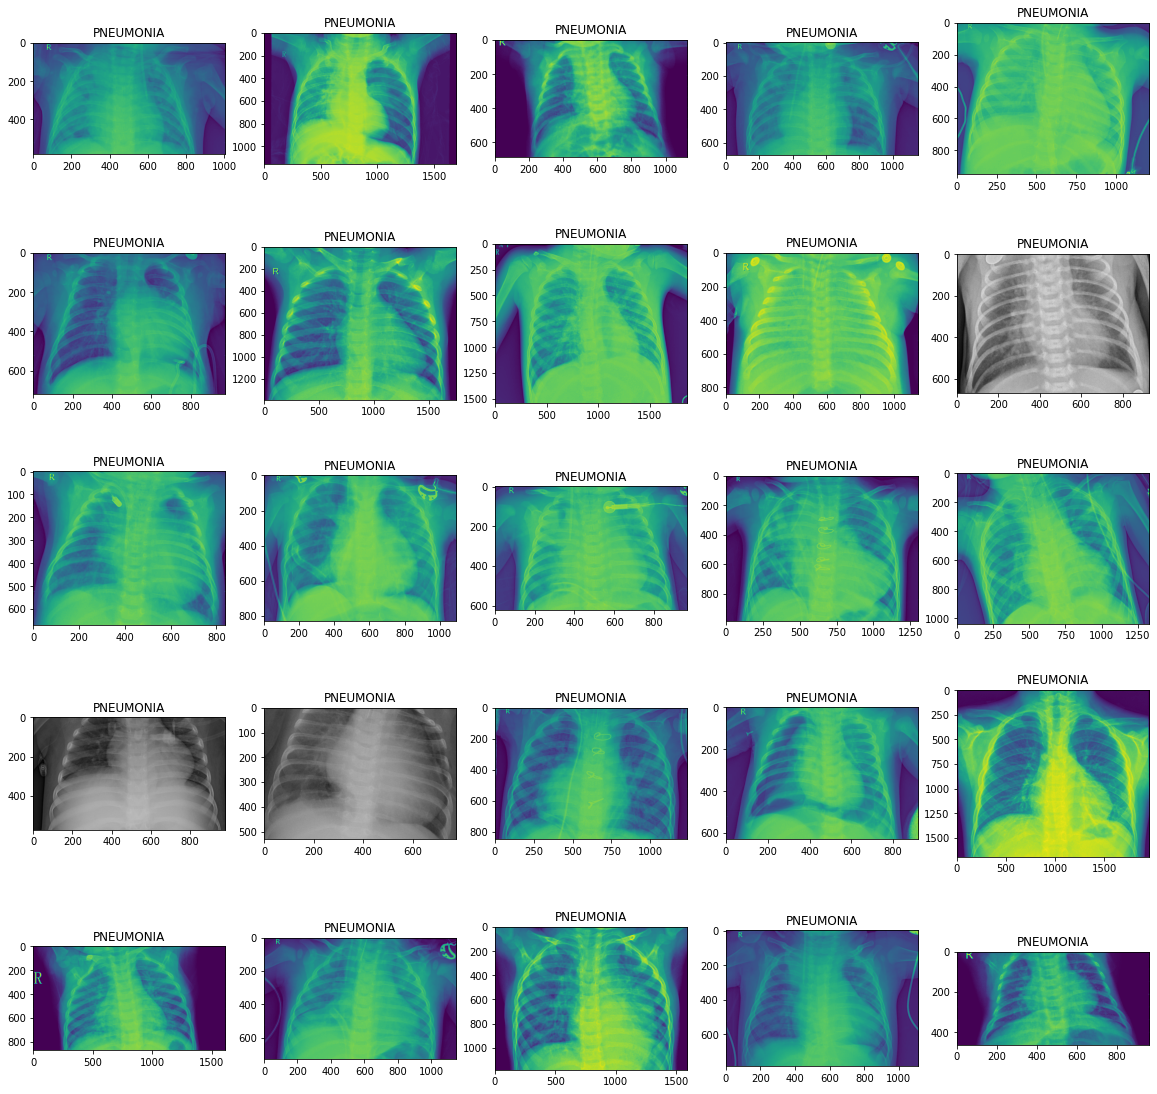

In [6]:
plt.figure(figsize=(20,20))
for i in range(25):
    ax = plt.subplot(5,5,i+1)
    plt.imshow(Image.open(training_set[i]))
    if check_label(training_set[i]): 
        plt.title("PNEUMONIA")
    else:
        plt.title("NORMAL")
        plt.axis("off")

###### Plot first 16 images in the validation set.

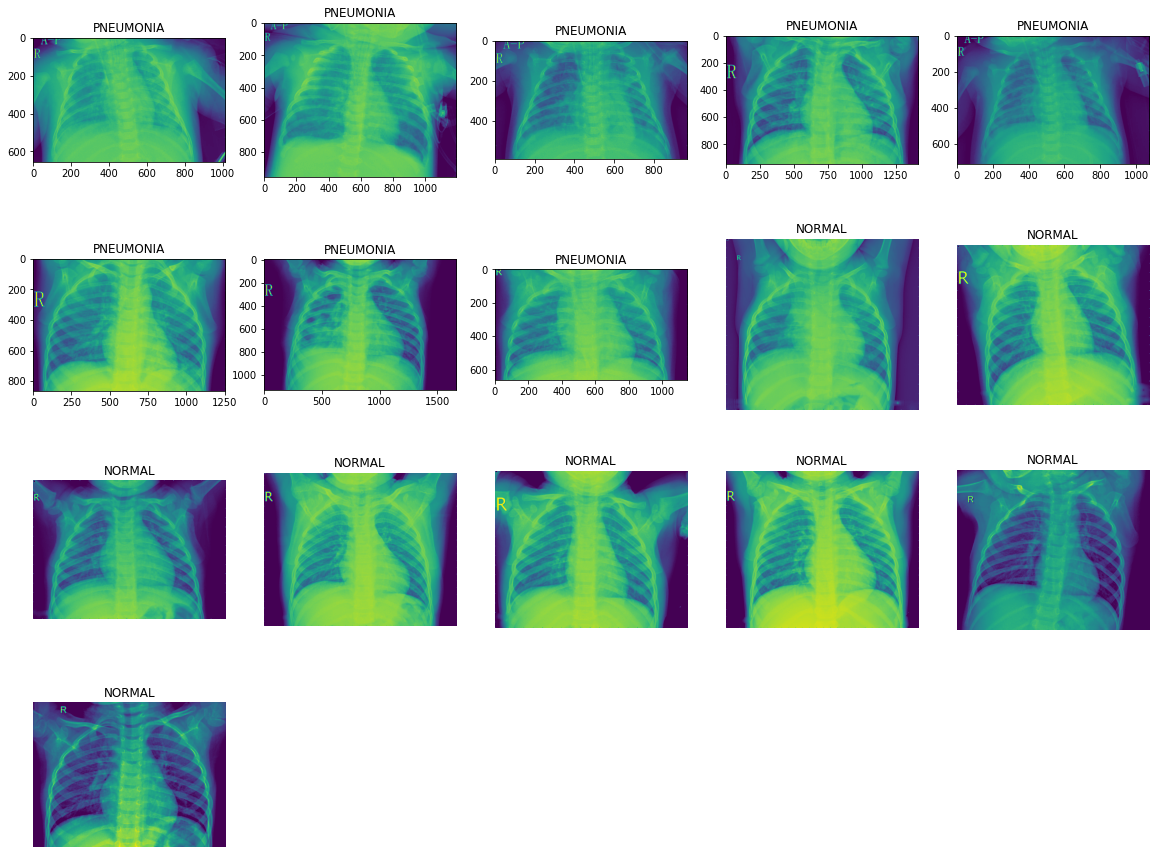

In [7]:
plt.figure(figsize=(20,20))
for i in range(16):
    ax = plt.subplot(5,5,i+1)
    plt.imshow(Image.open(validation_set[i]))
    if check_label(validation_set[i]): 
        plt.title("PNEUMONIA")
    else:
        plt.title("NORMAL")
        plt.axis("off")

###### Check ratio of labels (how balanced is the data?).

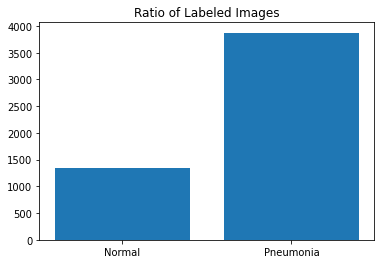

Normal:  1341
Pneumonia:  3875


In [8]:
# Counters for each label
normal = 0
pneumonia = 0

# Iterate through files in training set and check labels
for file in training_set:
    if check_label(file) == 0:
        normal += 1
    else:
        pneumonia += 1

counts = [normal, pneumonia]
plt.bar(['Normal', 'Pneumonia'], counts)
plt.title('Ratio of Labeled Images')
plt.show()

print('Normal: ', normal)
print('Pneumonia: ', pneumonia)

## 4. Data Preprocessing

###### Correct for data imbalancing.

In [9]:
initial_bias = np.log([pneumonia/normal])
print(initial_bias)

[1.06113006]


###### Instantiate keras normalization layer.

In [10]:
normalization_layer = tf.keras.layers.experimental.preprocessing.Rescaling(1./255)

###### Configure dataset for performance.

In [11]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

train_tensors = dirs['train'].cache().prefetch(buffer_size=AUTOTUNE)
val_tensors = dirs['val'].cache().prefetch(buffer_size=AUTOTUNE)

## 5. Build a model

###### Define the metrics to be used to evaluate the model later.

In [12]:
METRICS = [
      keras.metrics.TruePositives(name='tp'),
      keras.metrics.FalsePositives(name='fp'),
      keras.metrics.TrueNegatives(name='tn'),
      keras.metrics.FalseNegatives(name='fn'), 
      keras.metrics.BinaryAccuracy(name='accuracy'),
      keras.metrics.Precision(name='precision'),
      keras.metrics.Recall(name='recall'),
      keras.metrics.AUC(name='auc'),
]

### V1 - Set output bias

In [ ]:
# Function to make model
def make_model(metrics = METRICS, output_bias=None):
    if output_bias is not None:
        output_bias = tf.keras.initializers.Constant(output_bias)
#     model = keras.Sequential([
#         keras.layers.experimental.preprocessing.Rescaling(1./255),
#         keras.layers.Dense(16, activation='relu'),
#         keras.layers.Dropout(0.5),
#         keras.layers.Dense(1, activation='sigmoid', bias_initializer=output_bias),
#         ])
    model = tf.keras.Sequential([
      layers.experimental.preprocessing.Rescaling(1./255),
      layers.Conv2D(32, 3, activation='relu'),
      layers.MaxPooling2D(),
      layers.Conv2D(32, 3, activation='relu'),
      layers.MaxPooling2D(),
      layers.Flatten(),
      layers.Dense(128, activation='relu'),
      layers.Dense(1, activation='sigmoid')
    ])

    model.compile(optimizer=keras.optimizers.Adam(lr=1e-3),
                  loss=keras.losses.BinaryCrossentropy(from_logits=False),
                  metrics=metrics)

    return model

# Make and fit model
model = make_model()
history = model.fit(
  dirs['train'],
  validation_data=dirs['val'],
  epochs=NUM_EPOCHS
)

# Plot accuracy and loss
fig, ax = plt.subplots(1, 2, figsize=(10, 3))
ax = ax.ravel()

for i, met in enumerate(['accuracy', 'loss']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])  
    
# Test
test_data = []
test_labels = []
input_path = 'chest_xray/chest_xray/'
for cond in ['/NORMAL/', '/PNEUMONIA/']:
    for img in (os.listdir(input_path + 'test' + cond)):
        img = plt.imread(input_path+'test'+cond+img)
        img = cv2.resize(img, (200, 200))
        img = np.dstack([img, img, img])
        img = img.astype('float32') / 255
        if cond=='/NORMAL/':
            label = 0
        elif cond=='/PNEUMONIA/':
            label = 1
        test_data.append(img)
        test_labels.append(label)

test_data = np.array(test_data)
test_labels = np.array(test_labels)

preds = model.predict(test_ds)

acc = accuracy_score(test_labels, np.round(preds))*100
cm = confusion_matrix(test_labels, np.round(preds))
tn, fp, fn, tp = cm.ravel()

print('CONFUSION MATRIX ------------------')
print(cm)

print('\nTEST METRICS ----------------------')
precision = tp/(tp+fp)*100
recall = tp/(tp+fn)*100
print('Accuracy: {}%'.format(acc))
print('Precision: {}%'.format(precision))
print('Recall: {}%'.format(recall))
print('F1-score: {}'.format(2*precision*recall/(precision+recall)))

print('\nTRAIN METRIC ----------------------')
print('Train acc: {}'.format(np.round((history.history['accuracy'][-1])*100, 2)))

Epoch 1/10
 1/82 [..............................] - ETA: 0s - loss: 0.7439 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 18.0000 - fn: 46.0000 - accuracy: 0.2812 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.7506

###### Checkpoint weights.

In [ ]:
initial_weights = os.path.join(tempfile.mkdtemp(),'initial_weights')
model.save_weights(initial_weights)

### V2 - Set class weights

In [ ]:
# Scaling by total/2 helps keep the loss to a similar magnitude.
# The sum of the weights of all examples stays the same.
total = normal + pneumonia
weight_for_0 = (1 / normal)*(total)/2.0 
weight_for_1 = (1 / pneumonia)*(total)/2.0

class_weight = {0: weight_for_0, 1: weight_for_1}

print('Weight for class 0: {:.2f}'.format(weight_for_0))
print('Weight for class 1: {:.2f}'.format(weight_for_1))

In [ ]:
weighted_model = make_model()
weighted_model.load_weights(initial_weights)

weighted_history = weighted_model.fit(
    dirs['train'],
    validation_data=dirs['val'],
    epochs=NUM_EPOCHS,
    # The class weights go here
    class_weight=class_weight) 

# Plot accuracy and loss
fig, ax = plt.subplots(1, 2, figsize=(10, 3))
ax = ax.ravel()

for i, met in enumerate(['accuracy', 'loss']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])  
    
# Test
test_data = []
test_labels = []
input_path = 'chest_xray/chest_xray/'
for cond in ['/NORMAL/', '/PNEUMONIA/']:
    for img in (os.listdir(input_path + 'test' + cond)):
        img = plt.imread(input_path+'test'+cond+img)
        img = cv2.resize(img, (200, 200))
        img = np.dstack([img, img, img])
        img = img.astype('float32') / 255
        if cond=='/NORMAL/':
            label = 0
        elif cond=='/PNEUMONIA/':
            label = 1
        test_data.append(img)
        test_labels.append(label)

test_data = np.array(test_data)
test_labels = np.array(test_labels)

preds = model.predict(test_ds)

acc = accuracy_score(test_labels, np.round(preds))*100
cm = confusion_matrix(test_labels, np.round(preds))
tn, fp, fn, tp = cm.ravel()

print('CONFUSION MATRIX ------------------')
print(cm)

print('\nTEST METRICS ----------------------')
precision = tp/(tp+fp)*100
recall = tp/(tp+fn)*100
print('Accuracy: {}%'.format(acc))
print('Precision: {}%'.format(precision))
print('Recall: {}%'.format(recall))
print('F1-score: {}'.format(2*precision*recall/(precision+recall)))

print('\nTRAIN METRIC ----------------------')
print('Train acc: {}'.format(np.round((history.history['accuracy'][-1])*100, 2)))